# Определение выгодного тарифа для телеком компании

**Описание исследования.**

Клиентам компании «Мегалайн» (федерального оператора сотовой связи) предлагают два тарифных плана: «Смарт» и «Ультра».
_____
**Цель исследования.**

Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

_____
**Задача исследования.**

* Сделать предварительный анализ тарифов на небольшой выборке клиентов
* Проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Исходные данные.**
    
В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

*Описание тарифов*

Тариф «Смарт»

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 3 рубля
        сообщение: 3 рубля
        1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 1 рубль
        сообщение: 1 рубль
        1 Гб интернет-трафика: 150 рублей
        
*Описание таблиц*

Таблица users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

Таблица calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

        




## 1. Изучение данных из файлов

Подключим необходимые библиотеки 

In [1]:
# imports и глобальные настройки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st 

pd.set_option('display.float_format', '{:,.2f}'.format)

Посмотрим содержимое таблиц

In [2]:
calls = pd.read_csv('datasets/calls.csv')
internet = pd.read_csv('datasets/internet.csv')
messages = pd.read_csv('datasets/messages.csv')
tariffs = pd.read_csv('datasets/tariffs.csv')
users = pd.read_csv('datasets/users.csv')

display(calls)
display(internet)
display(messages)
display(tariffs)
display(users)


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,"1,246.32",2018-11-26,1499


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


**Вывод** Библиотеки подключены, файлы пс данными прочитаны

## 2. Подготовка и предобработка данных

Сделаем следующие действия:
* Удалим лишний столбец
* Переименуем столбцы с датой
* Приведем столбцы с датами из строкового типа в тип даты
* Проверим и исправим аномалии
* Проверим пропуски
* Объединим таблицы

Удалим лишний столбец

In [3]:
internet.drop('Unnamed: 0', axis=1, inplace=True)

Переименуем столбцы с датой

In [4]:
calls.rename(columns={'call_date': 'date'}, inplace=True)
messages.rename(columns={'message_date': 'date'}, inplace=True)
internet.rename(columns={'session_date': 'date'}, inplace=True)
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)

Приведем стольбцы с дадтами из строкового типа в тип даты

In [5]:
calls['date'] = pd.to_datetime(calls['date'], format='%Y-%m-%d')
messages['date'] = pd.to_datetime(messages['date'], format='%Y-%m-%d')
internet['date'] = pd.to_datetime(internet['date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

Проверим аномалии.

Посмотрим распределение количественных переменных: построим гистограммы для длительностей звонка, количества смс в день и длительности интернет-сессии.

Звонков с нулевой длительностью: 39613


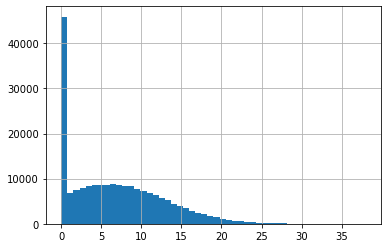

In [6]:
calls['duration'].hist(bins=50)
print('Звонков с нулевой длительностью:', len(calls.query('duration == 0')))

***Вывод:*** Есть множество звонков с нулевой длительностью. Очевидно это пропущенные звонки, не будем их удалять

<AxesSubplot:>

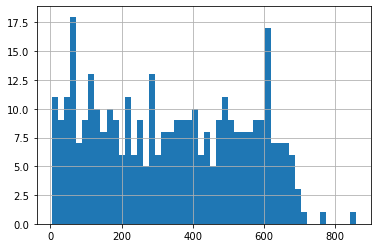

In [7]:
messages.groupby('date')['id'].count().hist(bins=50)

***Вывод:*** Очевидных анамалий по смс не выявлено

Интернет сессий с 0 мб: 19598


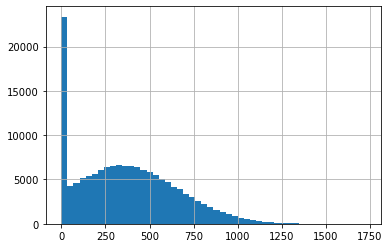

In [8]:
internet['mb_used'].hist(bins=50)
print('Интернет сессий с 0 мб:', len(internet.query('mb_used == 0')))

***Вывод:*** Есть множество интернет-сессий с нулевым траффиком. Можем их не использовать

In [9]:
internet = internet.query('mb_used > 0')

<a id='skips'></a>Проверим пропуски

In [10]:
display(calls.isna().sum())
display(messages.isna().sum())
display(users.isna().sum())
internet.isna().sum() 

id          0
date        0
duration    0
user_id     0
dtype: int64

id         0
date       0
user_id    0
dtype: int64

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

id         0
mb_used    0
date       0
user_id    0
dtype: int64

***Вывод:*** В таблице 'users' пропуски только в 'churn_date'. Это так задумано. Больше нигде пропусков нет

**Объединим  таблицы**

Добавим столбец с типом для каждой таблицы

In [11]:
calls['type'] = 'call'
messages['type'] = 'sms'
internet['type'] = 'inet'

In [12]:
data = pd.concat([calls, messages, internet], ignore_index=True, sort=False)
data = data.merge(users, on='user_id', how='left')
data['month'] = data['date'].dt.month
data.sort_values(by='date')

,id,date,duration,user_id,type,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,month
76907,1193_169,2018-01-01,13.29,1193,call,NaN,55,NaT,Тамбов,Арсен,Безруков,2018-01-01,smart,1
181903,1453_1095,2018-01-01,5.63,1453,call,NaN,50,NaT,Москва,Кузьма,Акуленко,2018-01-01,ultra,1
443164,1453_498,2018-01-01,NaN,1453,inet,209.31,50,NaT,Москва,Кузьма,Акуленко,2018-01-01,ultra,1
442978,1453_302,2018-01-01,NaN,1453,inet,794.96,50,NaT,Москва,Кузьма,Акуленко,2018-01-01,ultra,1
181239,1453_431,2018-01-01,19.92,1453,call,NaN,50,NaT,Москва,Кузьма,Акуленко,2018-01-01,ultra,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23727,1060_37,2018-12-31,7.71,1060,call,NaN,46,NaT,Калуга,Яков,Рудаков,2018-11-24,ultra,12
442647,1452_280,2018-12-31,NaN,1452,inet,670.70,74,NaT,Москва,Эмилия,Абалдуева,2018-06-19,ultra,12
230563,1121_83,2018-12-31,NaN,1121,sms,NaN,62,NaT,Белгород,Марта,Афанасова,2018-05-04,smart,12
230398,1119_314,2018-12-31,NaN,1119,sms,NaN,53,NaT,Петрозаводск,Олег,Сухарев,2018-04-22,smart,12


***Вывод***: лишние столбцы убрали, дату преобразовали, пропуски разобрали, таблицы объединили

**Расчёты и добавление результатов в таблицу**

Посмотрим на количество сделанных звонков и израсходованных минут разговора по месяцам

In [13]:
data['calls_in_month'] = data.query('type == "call"').groupby(['user_id', 'month'])['duration'].transform('count')
data['calls_dur_in_month'] = data.query('type == "call"').groupby(['user_id', 'month'])['duration'].transform('sum')
data['sms_count_in_month'] = data.query('type == "sms"').groupby(['user_id', 'month'])['user_id'].transform('count')
data['mb_in_month'] = data.query('type == "inet"').groupby(['user_id', 'month'])['mb_used'].transform('sum')

data

,id,date,duration,user_id,type,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_in_month,calls_dur_in_month,sms_count_in_month,mb_in_month
0,1000_0,2018-07-25,0.00,1000,call,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,47.00,318.80,NaN,NaN
1,1000_1,2018-08-17,0.00,1000,call,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,52.00,389.87,NaN,NaN
2,1000_2,2018-06-11,2.85,1000,call,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,43.00,158.90,NaN,NaN
3,1000_3,2018-09-21,13.80,1000,call,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,58.00,440.14,NaN,NaN
4,1000_4,2018-12-15,5.18,1000,call,NaN,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,46.00,312.98,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455436,1499_151,2018-10-11,NaN,1499,inet,752.72,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,10,NaN,NaN,NaN,"17,788.51"
455437,1499_152,2018-10-03,NaN,1499,inet,318.90,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,10,NaN,NaN,NaN,"17,788.51"
455438,1499_153,2018-12-14,NaN,1499,inet,490.13,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,12,NaN,NaN,NaN,"13,055.58"
455439,1499_155,2018-11-26,NaN,1499,inet,"1,246.32",35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,11,NaN,NaN,NaN,"17,963.31"


Теперь сформируем таблицу, где будут только пользователи и их данные по каждому месяцу. В конце добавим в таблицу данные о тарифах для будущих расчетов

In [14]:
users_months = data.groupby(['user_id', 'month']).first().reset_index()

# уберем неактуальные столбцы
users_months.drop(['type','duration', 'id', 'mb_used', 'date'], axis=1, inplace=True)
users_months = users_months.merge(tariffs, on='tariff', how='outer')
users_months.head(10)


,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_in_month,calls_dur_in_month,sms_count_in_month,mb_in_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,22.00,150.06,22.00,"2,253.49",1000,30720,3000,1950,150,1,1
1,1000,6,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,43.00,158.90,60.00,"23,233.77",1000,30720,3000,1950,150,1,1
2,1000,7,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,47.00,318.80,75.00,"14,003.64",1000,30720,3000,1950,150,1,1
3,1000,8,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,52.00,389.87,81.00,"14,055.93",1000,30720,3000,1950,150,1,1
4,1000,9,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,58.00,440.14,57.00,"14,568.91",1000,30720,3000,1950,150,1,1
5,1000,10,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,57.00,328.45,73.00,"14,702.49",1000,30720,3000,1950,150,1,1
6,1000,11,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,43.00,319.04,58.00,"14,756.47",1000,30720,3000,1950,150,1,1
7,1000,12,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,46.00,312.98,70.00,"9,817.61",1000,30720,3000,1950,150,1,1
8,1003,8,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,55.00,355.67,37.00,"8,565.21",1000,30720,3000,1950,150,1,1
9,1003,9,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,134.00,904.89,91.00,"12,468.87",1000,30720,3000,1950,150,1,1


In [15]:
users_months[users_months['calls_in_month'].isna()]

,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_in_month,calls_dur_in_month,sms_count_in_month,mb_in_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
151,1091,5,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,NaN,NaN,30.00,"10,703.37",1000,30720,3000,1950,150,1,1
152,1091,6,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,NaN,NaN,30.00,"10,236.19",1000,30720,3000,1950,150,1,1
153,1091,7,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,NaN,NaN,35.00,"16,444.98",1000,30720,3000,1950,150,1,1
154,1091,8,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,NaN,NaN,31.00,"12,633.88",1000,30720,3000,1950,150,1,1
155,1091,9,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,NaN,NaN,32.00,"16,597.11",1000,30720,3000,1950,150,1,1
156,1091,10,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,NaN,NaN,44.00,"15,644.73",1000,30720,3000,1950,150,1,1
157,1091,11,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,NaN,NaN,28.00,"11,864.25",1000,30720,3000,1950,150,1,1
158,1091,12,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,NaN,NaN,42.00,"13,280.45",1000,30720,3000,1950,150,1,1
204,1106,4,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra,NaN,NaN,9.00,"2,923.49",1000,30720,3000,1950,150,1,1
205,1106,5,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra,NaN,NaN,28.00,"16,573.01",1000,30720,3000,1950,150,1,1


<a id='skips_2'></a>Обработаем пропуски после объединения. Тут появляются пропущенные значения так как не во всех таблицах одинаковые столбцы

In [16]:
users_months.isna().sum()

user_id                     0
month                       0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
calls_in_month             40
calls_dur_in_month         40
sms_count_in_month        497
mb_in_month                13
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [17]:
users_months['calls_in_month'] = users_months['calls_in_month'].fillna(0)
users_months['calls_dur_in_month'] = users_months['calls_dur_in_month'].fillna(0)
users_months['sms_count_in_month'] = users_months['sms_count_in_month'].fillna(0)
users_months['mb_in_month'] = users_months['mb_in_month'].fillna(0)
users_months.isna().sum()

user_id                     0
month                       0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
calls_in_month              0
calls_dur_in_month          0
sms_count_in_month          0
mb_in_month                 0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Посчитаем помесячную выручку с каждого пользователя

In [18]:
# Методы для расчетов

# цена за перерасход трафика минут/смс
def price_overdraft(used, included, price_one):
    if np.isnan(used) or used <= included: return 0
    return (used - included) * price_one

# цена за перерасход интернета
def price_overdraft_mb(used, included, price_gb):
    if np.isnan(used) or used <= included: return 0
    return ((used - included) // 1024 + 1) * price_gb

# вычисляет выручку для переданой строки
def calc_revenue(row):   
    return (price_overdraft(row['calls_in_month'], row['minutes_included'], row['rub_per_minute'])
    + price_overdraft(row['sms_count_in_month'], row['messages_included'], row['rub_per_message'])
    + price_overdraft_mb(row['mb_in_month'], row['mb_per_month_included'], row['rub_per_gb'])
    + row['rub_monthly_fee']) 

In [19]:
users_months['revenue_month'] = users_months.apply(calc_revenue, axis=1)
users_months.sort_values(by='revenue_month', ascending=True)

,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_in_month,...,sms_count_in_month,mb_in_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_month
2122,1247,5,19,NaT,Москва,Адам,Тарасов,2018-05-23,smart,27.00,...,8.00,"6,974.12",50,15360,500,550,200,3,3,550.00
2395,1308,8,52,NaT,Москва,Инесса,Корнилова,2018-01-04,smart,40.00,...,23.00,"13,138.54",50,15360,500,550,200,3,3,550.00
1634,1144,4,65,NaT,Улан-Удэ,Ефим,Ефремов,2018-04-29,smart,6.00,...,3.00,690.00,50,15360,500,550,200,3,3,550.00
2393,1308,6,52,NaT,Москва,Инесса,Корнилова,2018-01-04,smart,27.00,...,22.00,"14,762.87",50,15360,500,550,200,3,3,550.00
1019,1007,6,65,NaT,Москва,Юна,Березина,2018-04-19,smart,68.00,...,26.00,"13,654.52",50,15360,500,550,200,3,3,550.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,1098,12,39,NaT,Челябинск,Элеонора,Озерова,2018-06-23,smart,80.00,...,14.00,"36,523.90",50,15360,500,550,200,3,3,"4,750.00"
228,1124,10,54,NaT,Махачкала,Альбин,Андрианов,2018-09-24,ultra,152.00,...,121.00,"49,745.69",1000,30720,3000,1950,150,1,1,"4,800.00"
3156,1486,11,35,NaT,Нижний Новгород,Матвей,Моргунов,2018-10-31,smart,108.00,...,96.00,"36,266.11",50,15360,500,550,200,3,3,"4,888.00"
1183,1042,12,42,NaT,Хабаровск,Константин,Добрынин,2018-11-25,smart,121.00,...,75.00,"37,165.69",50,15360,500,550,200,3,3,"5,025.00"


***Вывод по подготовке данных***
* лишние столбцы убрали, дату преобразовали, пропуски разобрали, таблицы объединили

Посчитали для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя

## 3. Исследовательский анализ данных

* Посчитаем среднее количество, дисперсию и стандартное отклонение. 
* Построим гистограммы. Опишем распределения.
* Опишем поведение клиентов

Посмотрим для каждого тарифа по выбранным показателям среднее количество, стандартное отклоненние, дисперсию

In [20]:
# выделим части таблицы с тарифами в отдельные переменные
ultra = users_months.query(f'tariff == "ultra"')[['user_id', 'calls_in_month', 'calls_dur_in_month', 'sms_count_in_month', 'mb_in_month']]
smart = users_months.query(f'tariff == "smart"')[['user_id', 'calls_in_month', 'calls_dur_in_month', 'sms_count_in_month', 'mb_in_month']]

display('Смарт среднее количество', smart.mean())
display('Ультра среднее количество', ultra.mean())
display('Отношение', smart.mean()/ultra.mean())

df = pd.DataFrame({'calls_in_month': [np.std(ultra['calls_in_month']), np.std(smart['calls_in_month'])],
                  'calls_dur_in_month': [np.std(ultra['calls_dur_in_month']), np.std(smart['calls_dur_in_month'])],
                  'sms_count_in_month': [np.std(ultra['sms_count_in_month']), np.std(smart['sms_count_in_month'])],
                  'mb_in_month': [np.std(ultra['mb_in_month']), np.std(smart['mb_in_month'])]}, index=['ultra', 'smart'])
display('Стандартное отклонение', df)

df = pd.DataFrame({'calls_in_month': [np.var(ultra['calls_in_month']), np.var(smart['calls_in_month'])],
                  'calls_dur_in_month': [np.var(ultra['calls_dur_in_month']), np.var(smart['calls_dur_in_month'])],
                  'sms_count_in_month': [np.var(ultra['sms_count_in_month']), np.var(smart['sms_count_in_month'])],
                  'mb_in_month': [np.var(ultra['mb_in_month']), np.var(smart['mb_in_month'])]}, index=['ultra', 'smart'])
display('Дисперсия', df)

'Смарт среднее количество'

user_id               1,246.51
calls_in_month           58.46
calls_dur_in_month      394.43
sms_count_in_month       33.38
mb_in_month          16,208.39
dtype: float64

'Ультра среднее количество'

user_id               1,263.09
calls_in_month           73.39
calls_dur_in_month      497.07
sms_count_in_month       49.36
mb_in_month          19,468.81
dtype: float64

'Отношение'

user_id              0.99
calls_in_month       0.80
calls_dur_in_month   0.79
sms_count_in_month   0.68
mb_in_month          0.83
dtype: float64

'Стандартное отклонение'

,calls_in_month,calls_dur_in_month,sms_count_in_month,mb_in_month
ultra,43.89,299.75,47.78,"10,082.05"
smart,25.93,179.92,28.22,"5,869.16"


'Дисперсия'

,calls_in_month,calls_dur_in_month,sms_count_in_month,mb_in_month
ultra,"1,926.73","89,851.19","2,282.95","101,647,713.26"
smart,672.57,"32,371.87",796.46,"34,447,035.50"


***Вывод***:

Пользовательи тарифа 'Ультра' в среднем тратят значительно больше единиц по всем видам трафика (от 63% и выше)

Стандартное отклонение по всем показателям у Ультра также значительно больше чем по тарифу 'Смарт'.

**Построим гистограммы по каждому виду трафика**

Гистограммы количества звонков в месяц


<AxesSubplot:>

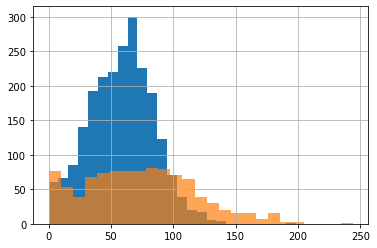

In [21]:
print('Гистограммы количества звонков в месяц')
smart['calls_in_month'].hist(bins=25)
ultra['calls_in_month'].hist(bins=25, alpha=0.7)

***Вывод***  
Тут, похоже, распределение Пуассона на обоих графиках. Судя по ним пользователи тарифа смарт чаще всего делают звонки от 50 до 80 раз в месяц. А по тарифу 'Ультра' больше всего пользователей делают от 40 до 120 звонков в месяц, но есть и те кто более 200 раз звонит. В Смарте же больше 120 уже большая редкость.

Гистограммы длительностей звонков в месяц


<AxesSubplot:>

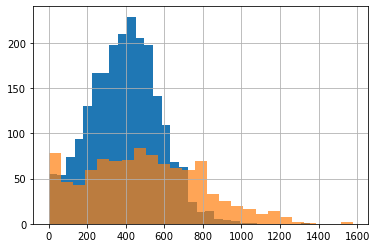

In [22]:
print('Гистограммы длительностей звонков в месяц')
smart['calls_dur_in_month'].hist(bins=30)
ultra['calls_dur_in_month'].hist(bins=25, alpha=0.7)

***Вывод***: Тут также распределение Пуассона. В смарте чаще всего разговаривают от 220 до 550 мин в месяц, а в ультре график очень пологий в и разброс от 0 до 800 мин в месяц, больше уже редкость.


Гистограммы количества звонков в месяц


<AxesSubplot:>

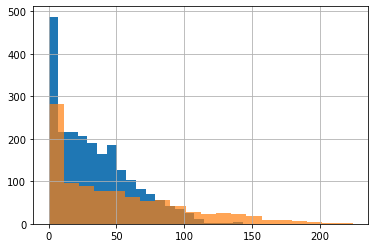

In [23]:
print('Гистограммы количества звонков в месяц')
smart['sms_count_in_month'].hist(bins=20)
ultra['sms_count_in_month'].hist(bins=20, alpha=0.7)

***Вывод***: Тут также распределение Пуассона. Судя по рафикам большое количество людей вообще не использует смс или использует очень мало. В смарте основная часть пишет до 50 смс. а в ультре - до 80-100 смс. В смарте почти никогда больше 110 смс не пишут, а в ультре могут и больше 200.

<AxesSubplot:>

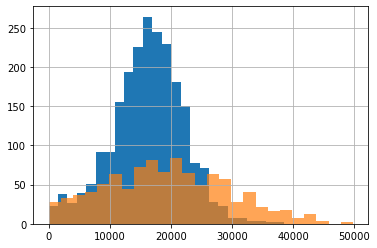

In [24]:
smart['mb_in_month'].hist(bins=25, grid=True)
ultra['mb_in_month'].hist(bins=25, grid=True, alpha=0.7)

***Вывод***: Графики имеют распределение похожее на нормальное. Интересно, что бОльшая часть пользователей смарта потребляют немного более 15Гб, включенных в тариф, очень многие до 22Гб, а некоторые более 30Гб. В ультре большинство использкет около 20Гб, а вот потребителей более включенных в тариф резко падает после отметки в 30Гб.

## Проверим гипотезы

Гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


Нулевые гипотезы сформулируем так, что в каждом рассматриваемом случае выручки равны.
Проверим нулевые гипотезы и сравним полученный уровень значимости (p-значение) с общепринятым alpha=0.05

***Нулевая гипотеза 1***: средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова

***Альтернативаная гипотеза 1***: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [25]:
results = st.ttest_ind(users_months.query('tariff == "smart"')['revenue_month'], users_months.query('tariff == "ultra"')['revenue_month'])
print('p-значение: ', results.pvalue)

p-значение:  1.7908299298705238e-242


***Вывод***: p-значение имеет значение сильно меньше 0.05, значит велика вероятность что нулевая гипотеза не верна. Склоняемся в пользу альтернативной гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различяется

***Нулевая гипотеза 2***: средняя выручка пользователей из Москвы такая же как выручка пользователей из других регионов.

***Альтернативная гипотеза 2***: средняя выручка пользователей из Москвы и пользователей из других регионов различается

In [26]:
results = st.ttest_ind(users_months.query('city == "Москва"')['revenue_month'], users_months.query('city != "Москва"')['revenue_month'])
print('p-значение: ', results.pvalue)

p-значение:  0.2959013162901811


***Вывод***: p-значение значительно больше 0.05, значит нет оснований отвергать нулевую гипотезу.

**Общий вывод**

Вероятно:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы такая же как выручка пользователей из других регионов

## Общий вывод

Повторим выводы, сделанные выше:
* Пользовательи тарифа 'Ультра' в среднем тратят значительно больше единиц по всем видам трафика (от 63% и выше).
* Стандартное отклонение по всем показателям у Ультра также значительно больше чем по тарифу 'Смарт'.
* в смарте чаще всего делают звонки от 50 до 80 раз в месяц. А по тарифу 'Ультра' больше всего пользователей делают от 40 до 120 звонков в месяц, но есть и те кто более 200 раз звонит. В Смарте же больше 120 уже большая редкость.
* в смарте чаще всего разговаривают от 220 до 550 мин в месяц, а в ультре график очень пологий в и разброс от 0 до 800 мин в месяц, больше уже редкость.
* большое количество людей в обоих тарифах вообще не использует смс или использует очень мало. В смарте основная часть пишет до 50 смс. а в ультре - до 80-100 смс. В смарте почти никогда больше 110 смс не пишут, а в ультре могут и больше 200.
* бОльшая часть пользователей смарта потребляют немного более 15Гб, включенных в тариф, очень многие до 22Гб, а некоторые более 30Гб. В ультре большинство использкет около 20Гб, а вот потребителей более включенных в тариф резко падает после отметки в 30Гб.
* вероятно: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* вероятно: средняя выручка пользователей из Москвы такая же как выручка пользователей из других регионов



**Вывод**

Из вышеприведенных выводов получается что пользователи тарифа Ультра редко превышают потребление по всем видам трафика больше чем в 2 раза по сравнению с тарифом Смарт. А по скольку стоимость тарифа Ультра выше аж в 3,5 раз, то для компании он выгоднее.